In [1]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from google.colab import drive
from PIL import Image

In [2]:
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
%cd ..
%cd gdrive/MyDrive/shopee-product-matching

/
/gdrive/MyDrive/shopee-product-matching


In [4]:
train_df = pd.read_csv('train.csv')
train_df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [5]:
# label group is supposed 'target'
# all products fall into some label group, thus we can define a dictionary mapping each group to posting_id
label_dict = train_df.groupby('label_group').posting_id.agg('unique').to_dict()
train_df['target'] = train_df['label_group'].map(label_dict)
train_df.head()

,posting_id,image,image_phash,title,label_group,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"


In [6]:
# find text duplicates 
train_df.title.value_counts()[:10]

Koko syubbanul muslimin koko azzahir koko baju                                                          9
Baju Koko Pria Gus Azmi Syubbanul Muslimin Kombinasi Hadroh Azzahir Hilw HO187 KEMEJA KOKO PRIA BAJU    8
100 Pcs Ikat Rambut Karet Polos Elastis Gaya Korea untuk Wanita                                         6
Monde Boromon Cookies 1 tahun+ 120gr                                                                    6
Viva Air Mawar                                                                                          6
Emina Glossy Stain                                                                                      6
Shannen lipstik shanen creamy lip paint                                                                 5
Viva Air Mawar 100ml                                                                                    5
Avoskin Miraculous Retinol Toner                                                                        5
SPONGE MAKE UP COLORFULL UNIK BLENDED BLENDING

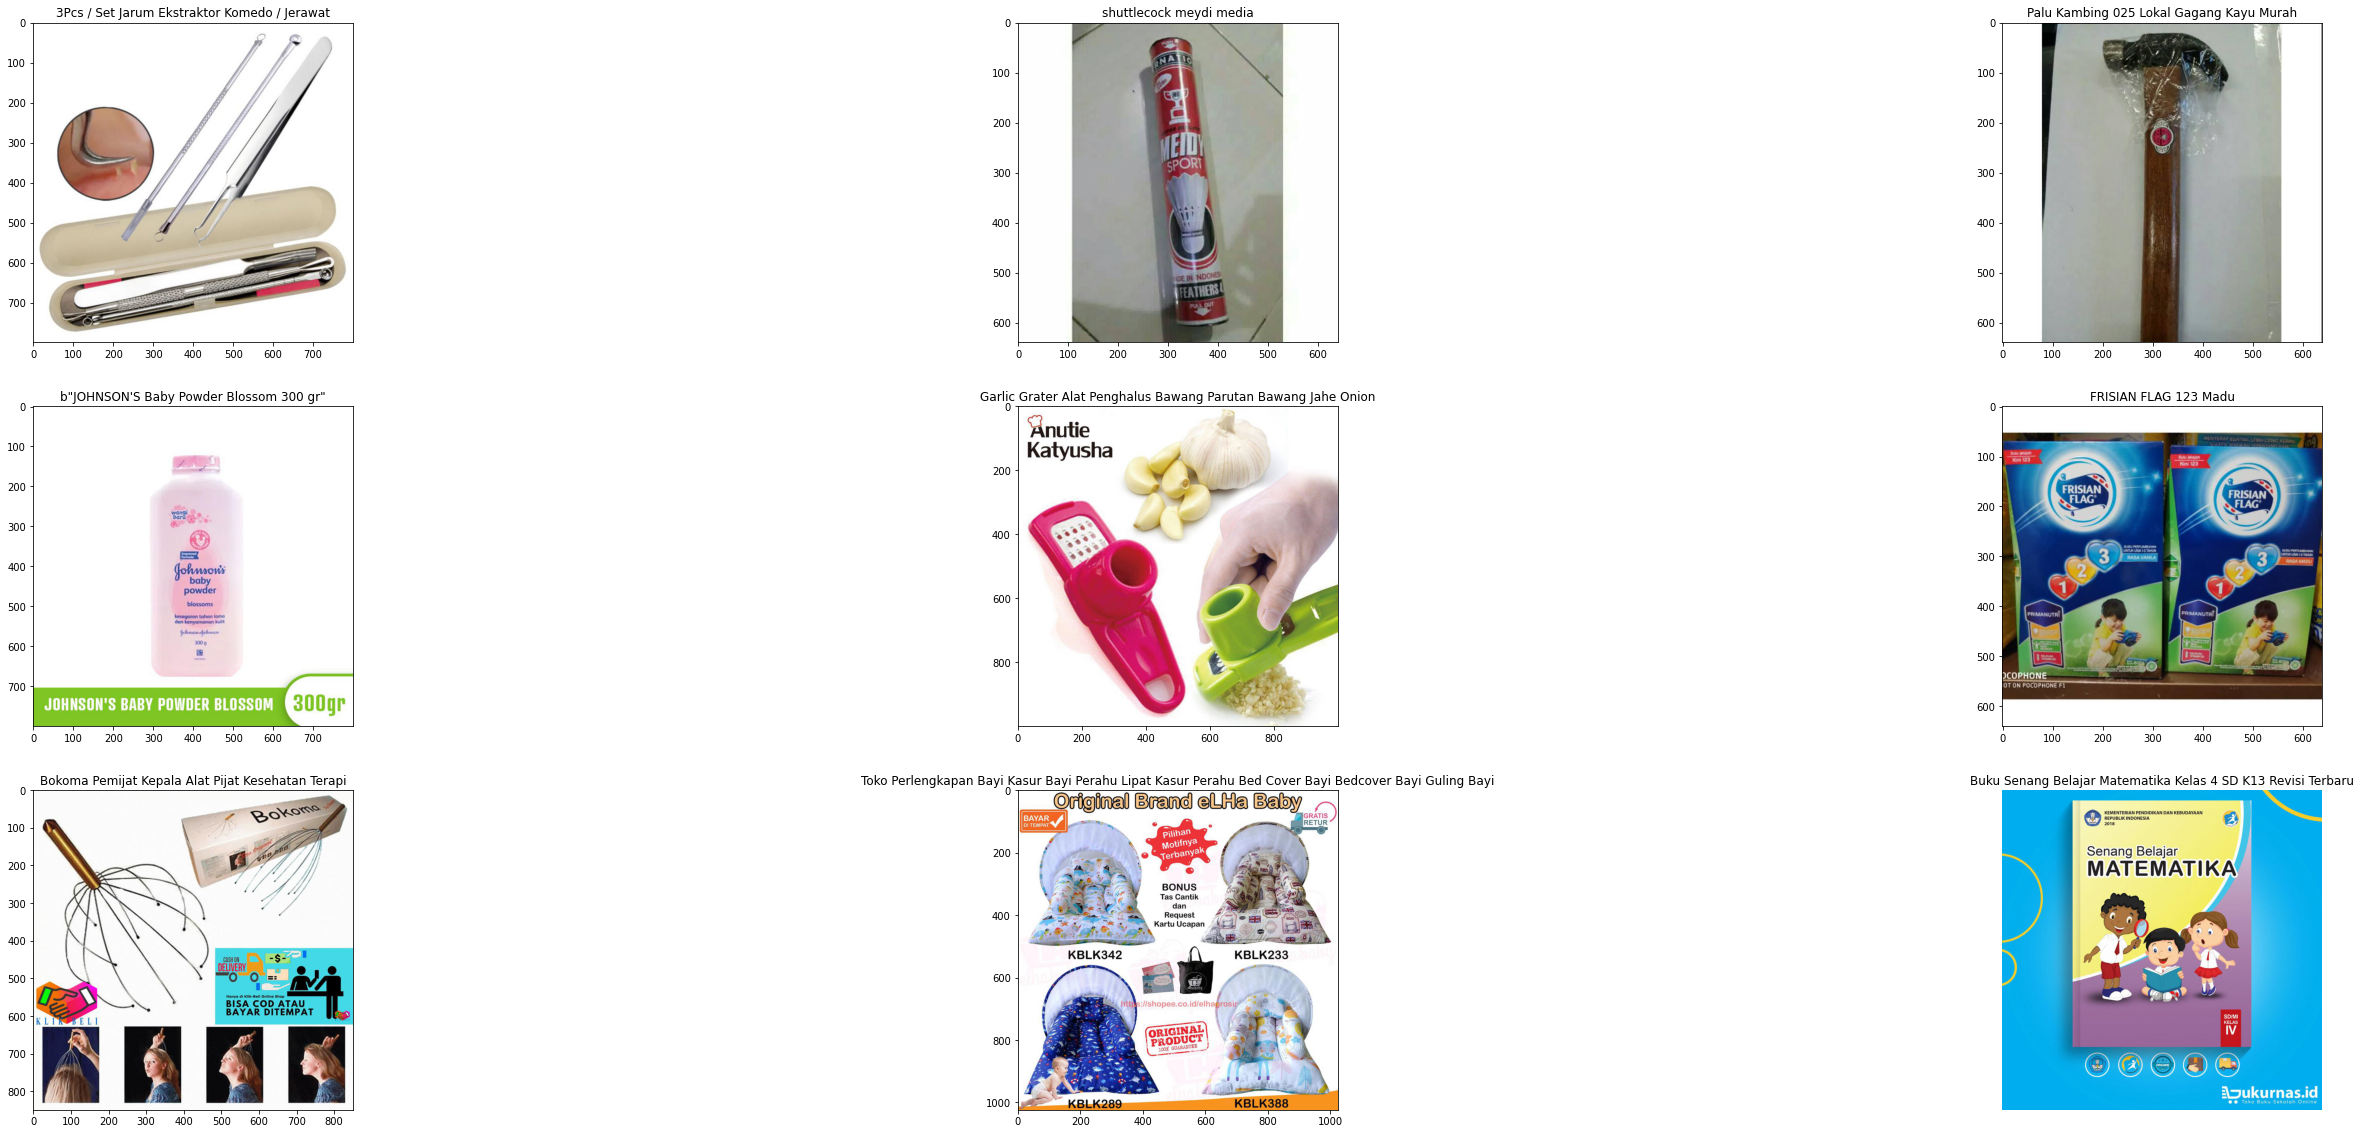

In [7]:
# vizualize some images
def display_train(train, train_path, rows, cols):
  fig, ax = plt.subplots(rows, cols, figsize=(50, 20))
  rands = random.sample(range(0, train_df.image.shape[0]), rows*cols)
  for i in range(rows):
    for j in range(cols):
      im = mpimg.imread(train_path+'/'+ train_df.image[rands[i*cols+j]])
      plt.axis('off')
      ax[i, j].set_title(train_df.title[rands[i*cols+j]])
      ax[i, j].imshow(im)


train_path = 'train_images'
display_train(train_df, train_path, 3, 3)

In [8]:
# calculate baseline by using perceptual hash 
baseline = train_df.groupby('image_phash').posting_id.agg('unique').to_dict()
train_df['baseline'] = train_df['image_phash'].map(baseline)

In [9]:
# taken from https://www.kaggle.com/cdeotte/part-2-rapids-tfidfvectorizer-cv-0-700
def getMetric(col):
    def f1score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return 2*n / (len(row.target)+len(row[col]))
    return f1score

In [10]:
baseline_preds = train_df.apply(getMetric('baseline'),axis=1)
print('CV score for baseline =', baseline_preds.mean())

CV score for baseline = 0.5530933399167943


## approach, use image and text embeddings to find nearest neighbors


In [11]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers